# Lip Reading in TensorFlow

An attempt at using TensorFlow to analyse pixels in video files (without sound) of someone talking and produce an estimation of their speech.

I decided to use the GRID dataset, which has a good variety of speakers, although the sentence format is quite formulaic. Though this may result in a degree of overfitting, human speech is a very wide dataset and focusing on just one speaker and sentence format enabled me to create a more effective model.

I based my Neural Network on the one described in LipNet, which can be found here -

https://arxiv.org/pdf/1611.01599


The dataset can be downloaded here (speaker 20) -

https://spandh.dcs.shef.ac.uk/gridcorpus/

The video clips come in the format command(4) + colour(4) + preposition(4) + letter(25) + digit(10) + adverb(4) (Where each number denotes how many choices there are for each category). For example "place green at i four please", or "set blue in k nine now". This yields 64000 possible sentences. See this video for an example of speaker 20.




<video controls src="s20vids/swwa7p.mpg">

The alignments (or subtitles) for the videos come in the format: <br>

0 11500 sil <br>
11500 22500 set <br>
22500 30500 white <br>
30500 33000 with <br>
33000 34750 a <br>
34750 44750 seven <br>
44750 57000 please <br>
57000 74500 sil <br>

Where the two numbers correspond to the frames in which the word is being said and "sil" indicates silence.


This task represents a temporal classification task, where the model is challenged with corresponding movements in the speakers mouth to a list of vocabulary. We enable this using CTC (Connectionist Temporal Classification) loss, a method devised by Alex Graves in 2006. CTC allows for a probabilistic mapping of input sequences to output sequences without requiring explicit alignment. Each input frame can mapt to either a label in the vocabulary or a blank token, which is then transformed to an alignment when we remove the blank tokens and repeated labels. For example, a video of a person saying hello may be encoded as <br>"------hhhheeelllo---", <br>and then turned into "hello". The loss is calculated as -log P(Y∣X) where X is the input sequence and Y is the output sequence. The advantages of this method are that there is no need for explicit correspondence between input and output (this is good because lip movements may be slightly different even when speaking the same word), and it works well with variable length sequences (such as sentences).

![alt text](LipnetCTC.jpg)
<br>An example of CTC, taken from the LipNet paper

My aim for this project is to get consistently good results on the speaker I chose to train on, then attempt to test on another speaker just to see if the model has any generalisation capability

In [47]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import List
from typing import Tuple

from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Orthogonal
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten, Lambda
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [48]:
tf.config.list_physical_devices('GPU')
os.environ["OPENCV_LOG_LEVEL"] = "SILENT" 

Using GPU was crucial for this task, as it is very computationally expensive. On my laptop, epochs had an eta of 2 hours on CPU and 3 minutes on GPU. When training for over 50 epochs, CPU computation is not an option. I have a NVIDIA RTX4060 Laptop GPU and am using Ubuntu 24.04, with CUDA 12.1, CUDNN 8.9 and TensorRT 8.6. This setup works with Tensorflow 2.15.

In [49]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU configured successfully")
else:
    print("No GPU found, using CPU")

GPU configured successfully


# Data Loading and Preprocessing

Here we implement functions to load the videos and alignments and one to return the two matched files. We implement a mappable function that takes the file path and returns a tuple of tensors containing the frames and alignments, which we then use in the data pipeline to create our dataset.

In [24]:
def load_video(path: str) -> List[float]: # function to load a video as frames from a path, returns a  lsit of frames
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        if not ret:
            break
        frame = tf.image.rgb_to_grayscale(frame)
        # Check the shape of the frame before slicing
        if frame.shape[0] >= 236 and frame.shape[1] >= 250:
            frames.append(frame[190:236, 110:250, :])
        else:
            print(f"Skipping frame with shape {frame.shape} from video {path} as it is too small for slicing")
            continue
    cap.release()

    if not frames:
        raise ValueError("No valid frames found in the video")

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std # divide by standard deviation to normalize the frames


These conversion functions are taken from https://keras.io/examples/audio/ctc_asr/ <br>
They enable us to convert between the array of numbers signifying the letters and the sentence in chars.

In [25]:
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "] # create vocabulary

char_to_num = tf.keras.layers.StringLookup(vocabulary=characters, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [26]:
def load_alignments(path:str) -> List[str]: # function to load the corresponding alignment
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':  # all lines that are not "silence"
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]
     # add to tokens array as numbers (using conversion function)

In [27]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('.', 's20vids', f'{file_name}.mpg')
    alignment_path = os.path.join('.', 'align', f'{file_name}.align')
    
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video file not found: {video_path}")
    if not os.path.exists(alignment_path):
        raise FileNotFoundError(f"Alignment file not found: {alignment_path}")
    
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    return frames, alignments

In [11]:
testing = './s20vids/swwa7p.mpg'

Below is essentially what the neural net sees, a tensor of shape (75, 46, 140, 1), where 75 is the amount of frames, 46/140 is the height/width of the sliced frame, and 1 is the grayscale value. There is then a tensor of shape (29,), which is a variable length tensor that corresponds to the letters in the alignment using our vocabulary

In [12]:
print(load_data(tf.convert_to_tensor(testing))) 
                                      

(<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[1.368082  ],
         [1.3422692 ],
         [0.8001989 ],
         ...,
         [5.6013923 ],
         [5.678831  ],
         [5.523954  ]],

        [[1.3422692 ],
         [1.3422692 ],
         [0.8001989 ],
         ...,
         [5.6013923 ],
         [5.678831  ],
         [5.523954  ]],

        [[1.368082  ],
         [1.368082  ],
         [0.77438605],
         ...,
         [5.5755796 ],
         [5.6272054 ],
         [5.5755796 ]],

        ...,

        [[0.6195088 ],
         [0.6195088 ],
         [0.38719302],
         ...,
         [5.317451  ],
         [5.2658253 ],
         [5.2658253 ]],

        [[0.59369594],
         [0.5678831 ],
         [0.38719302],
         ...,
         [5.317451  ],
         [5.2658253 ],
         [5.2658253 ]],

        [[0.59369594],
         [0.5420702 ],
         [0.36138016],
         ...,
         [5.3432636 ],
         [5.2658253 ],
         [5.2658253 ]]],


 

In [13]:
def mappable_function(path:str) ->Tuple[tf.Tensor, tf.Tensor]: # function takes in a path and returns the frames and alignments
      result = tf.py_function(load_data, [path], (tf.float32, tf.int64)) # load_data returns a tuple of two tensors
      return result

### Using MatPlotLib to visualise frames

As you can see, MPL can be used to show what the NN sees. I used this (and trial + error on as many clips as I had patience for ) to center the mouth in the image, as this is the only part of the face we are interested in.

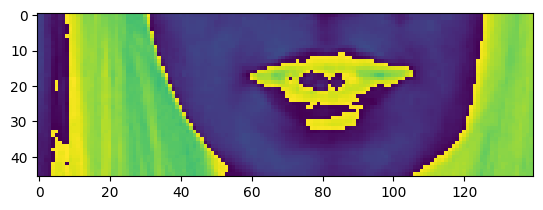

In [12]:
frames, alignments = load_data(tf.convert_to_tensor(testing))
plt.imshow(frames[34])

In [12]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue with k seven please'>

# Dataset creation

Now it is time to create our dataset. We create batches of 2 videos, and then split our data (after shuffling) into training and testing data for validation. I chose a batch size of 2 where the LipNet researchers used 50 as their batch size, but they were training on a much larger dataset as they used 

In [28]:
try:
    data = tf.data.Dataset.list_files('./s20vids/*.mpg') # all videos in s20 folder
    data = data.shuffle(500, reshuffle_each_iteration=False)
    data = data.map(mappable_function)
    data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40])) # create batches of 2 videos
    data = data.prefetch(tf.data.AUTOTUNE)
    # split data into training and testing
    train = data.take(450)
    test = data.skip(450)
except Exception as e:
    print("dataset error", e)

In [29]:
frames, alignments = data.as_numpy_iterator().next()

In [15]:
vis = data.as_numpy_iterator()

In [16]:
val = vis.next(); val[0]

array([[[[[0.4164586 ],
          [0.05552781],
          [6.774393  ],
          ...,
          [5.8581843 ],
          [5.6083093 ],
          [5.636073  ]],

         [[0.4164586 ],
          [0.05552781],
          [6.746629  ],
          ...,
          [5.8581843 ],
          [5.663837  ],
          [5.691601  ]],

         [[0.27763906],
          [7.052032  ],
          [6.746629  ],
          ...,
          [5.7748923 ],
          [5.7471285 ],
          [5.7193646 ]],

         ...,

         [[6.857685  ],
          [6.829921  ],
          [6.829921  ],
          ...,
          [5.580545  ],
          [5.4694896 ],
          [5.580545  ]],

         [[6.857685  ],
          [6.829921  ],
          [6.829921  ],
          ...,
          [5.580545  ],
          [5.4694896 ],
          [5.580545  ]],

         [[6.829921  ],
          [6.829921  ],
          [6.829921  ],
          ...,
          [5.552781  ],
          [5.4694896 ],
          [5.580545  ]]],


        [[[0.4164

Here is a visualisation of frame 0, 10, 20, 30, 40 and 50. It shows the changes in the video as the speaker moved their mouth.

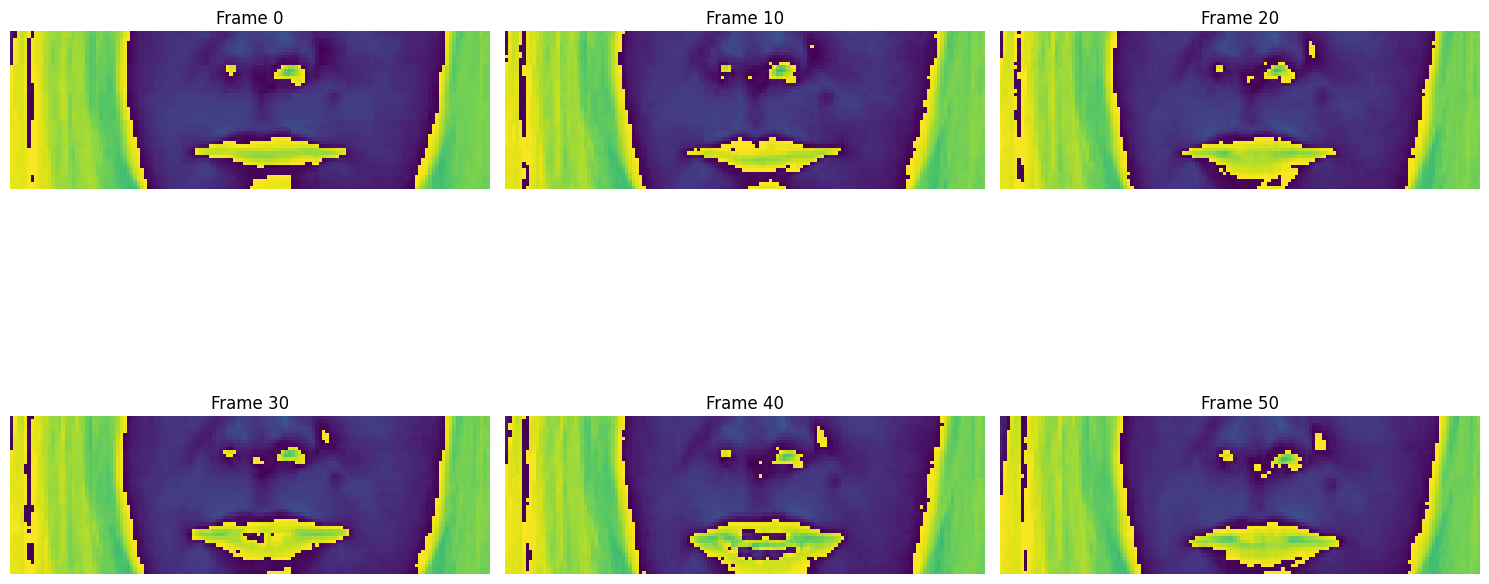

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(6):  # 6 frames total
    frame_idx = i * 10  # Show every 10th frame (0,10,20,30,40,50)
    axes[i].imshow(val[0][0][frame_idx])
    axes[i].set_title(f'Frame {frame_idx}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

This is a transcript of the video. Notice how we use the num_to_char function to convert the array to a sentence.

In [18]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place green at i four soon'>

# Non-Neural Baselines

Interestingly, in the LipNet paper, researchers used hearing-impaired people who can lipread as a baseline. They achieved a word error rate of 47.7% (Although one subject achieved as high as 57.3%) on 300 random videos from the dataset after being exposed to 10 minutes of annotated videos. This outperformed every other model they tested apart from the LSTM model, which is a reason I chose to use LSTM in my model.

For our non-neural common sense baseline, I attempted to find the most common word in all the alignments in our train dataset, then repeat this for the average length the alignments. This is actually cheating really, because we are using the "answer sheet" (the alignments set) to calculate our answer. However I then use a basic loss function that compares the characters in a random test alignment to our prediction.

In [30]:
def create_baseline_stats(train_data):
    # Initialize counters
    total_words = 0
    total_chars = 0
    word_counts = {}
    num_samples = 0
    
    # Iterate through training data
    for batch in train_data:
        alignments = batch[1]
        
        # Convert alignments to text
        for alignment in alignments:
            text = tf.strings.reduce_join(
                num_to_char(alignment)
            ).numpy().decode('utf-8').strip()
            
            words = text.split()
            
            # Count words
            for word in words:
                word_counts[word] = word_counts.get(word, 0) + 1
                    
            total_words += len(words)
            total_chars += len(text)
            num_samples += 1
            
    # Calculate stats
    avg_word_length = total_words / num_samples 
    avg_char_length = total_chars / num_samples
    most_common = max(word_counts.items(), key=lambda x: x[1])[0]
    
    print(f"Most common word: {most_common}")
    print(f"Average words per sample: {avg_word_length:.2f}")
    print(f"Average characters per sample: {avg_char_length:.2f}")
    
    return most_common, int(avg_word_length), int(avg_char_length)

In [35]:
def baseline_loss(test_data, pred):
    # Get random test sample
    test_batch = next(test_data.as_numpy_iterator())
    test_alignment = test_batch[1][0]
    
    # Convert test alignment to text
    actual_text = tf.strings.reduce_join(
        num_to_char(test_alignment)
    ).numpy().decode('utf-8').strip()
    
    # Calculate character-level loss
    char_errors = sum(1 for a, b in zip(pred, actual_text) if a != b)
    char_error_rate = char_errors / len(actual_text)
    
    print(f"Prediction: {pred}")
    print(f"Actual: {actual_text}")
    print(f"Character Error Rate: {char_error_rate:.2%}")

In [36]:
def word_baseline(most_common: str, avg_word_length: int) -> str:
    #Creates baseline using most common word
    return (most_common + " ") * avg_word_length

# Test functions
most_common, avg_words, avg_chars = create_baseline_stats(train)

word_pred = word_baseline(most_common, avg_words)

baseline_loss(test, word_pred)


[mpeg1video @ 0x724a7801e380] ac-tex damaged at 22 17
[mpeg1video @ 0x724a7801e380] Warning MVs not available


Most common word: lay
Average words per sample: 6.02
Average characters per sample: 24.80


[mpeg1video @ 0x724a840cbd40] ac-tex damaged at 22 17
[mpeg1video @ 0x724a840cbd40] Warning MVs not available


Prediction: lay lay lay lay lay lay 
Actual: lay green at d six soon
Character Error Rate: 82.61%


Ok, as we can see, a pretty terrible prediction, and it took ages to complete. Lets try another method. I will use the most common character in the english language, "E", and repeat this for the average length of the alignments. 

In [32]:
def char_baseline(avg_char_length: int) -> str:
    #Creates baseline using 'e' character
    return 'e' * avg_char_length

char_pred = char_baseline(avg_chars)

baseline_loss(test, char_pred)


[mpeg1video @ 0x724a98046fc0] ac-tex damaged at 22 17
[mpeg1video @ 0x724a98046fc0] Warning MVs not available


Prediction: eeeeeeeeeeeeeeeeeeeeeeee
Actual: lay green with e six again
Character Error Rate: 80.77%


Still pretty awful performance on this attempt. Lets try a deep learning approach instead. 

# Neural Network Approach

## Building the NN

I based this model on LipNet. There are various TensorFlow implementations, but I felt this method was the cleanest and most effective. I based it on https://github.com/rizkiarm/LipNet , which implemented in TensorFlow 1.x. I used LSTM's where they and the original LipNet paper used GRU's due to LSTM's advantages on complex tasks, despite the increase in computation. <br><br>I use three 3D Convolutional Layers with size 3x3x3 to extract the spatiotemporal features (with ReLU activation), with MaxPooling Layers to downsample the data to reduce the spatial dimensions while retaining signifigant features. <br><br>As the spatial dimensions shrink, the filters increase from 128 to 256 to extract more complex features, then return to 75 to match the frame size. The result of this is highly compressed spatial representation with meaningful temporal layers. <br><br >We then use a TimeDistributed Flatten Layer, which flattens the spatial features while preserving the temporal structure. <br><br> We then use two Bidirectional LSTM layers, which aim to learn the temporal relationships in both forward and backward directions. This is important because lipreading is heavily dependant on mouth movement, not just mouth position. We add a dropout of 0.5 to both of these layers to prevent overfitting. <br><br> Our final layer is a Dense Layer, classifying each frame into a character with a softmax to output the probability. We are left with a sequence of probabilities for each frame. 

In [38]:

model = Sequential()

# First Conv3D Layer
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))
print(f"After First Conv3D: {model.output_shape}")

# Second Conv3D Layer
model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))
print(f"After Second Conv3D: {model.output_shape}")

# Third Conv3D Layer
model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))
print(f"After Third Conv3D: {model.output_shape}")

#TimeDistributed Flatten Layer
model.add(TimeDistributed(Flatten()))
print(f"After TimeDistributed Flatten: {model.output_shape}")


# First Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(128, kernel_initializer=Orthogonal(), return_sequences=True)))
print(f"After First Bidirectional LSTM: {model.output_shape}")
model.add(Dropout(.5))

# Second Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(128, kernel_initializer= Orthogonal(), return_sequences=True)))
print(f"After Second Bidirectional LSTM: {model.output_shape}")
model.add(Dropout(.5))

# Dense Layer
model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))
print(f"After Dense Layer: {model.output_shape}")


After First Conv3D: (None, 75, 23, 70, 128)
After Second Conv3D: (None, 75, 11, 35, 256)
After Third Conv3D: (None, 75, 5, 17, 75)
After TimeDistributed Flatten: (None, 75, 6375)
After First Bidirectional LSTM: (None, 75, 256)
After Second Bidirectional LSTM: (None, 75, 256)
After Dense Layer: (None, 75, 41)


In [22]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

### Untrained prediction

First of all, lets make a prediction using the untrained model.

In [23]:
yhat = model.predict(val[0])

2025-01-10 12:56:10.367550: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


1/1 [==============================] - 19s 19s/step


In [24]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjju'>

As you can see, not a very succesful prediction

### Learning Rate and Loss Function

In [41]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [42]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        print(f"Epoch {epoch+1} finished")
        if (epoch+1) % 5 == 0: # produce example every 5 in order to speed up training process 
            data = self.dataset.next()
            yhat = self.model.predict(data[0])
            decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
            for x in range(len(yhat)):
                print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
                print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
                print('~'*100)

I chose Adam as an optimizer and a learning rate of 0.0001 as this is what the original Lipnet researchers chose. I considered adding a variable learning rate that would decrease as epochs increased but I reached a good level of accuracy without it and felt it was unnecessary.

In [43]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [44]:
checkpoint_path = os.path.join('./models','lipcheckpoint.weights.h5')
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='loss', save_best_only=True, save_weights_only=True)

In [45]:
example_callback = ProduceExample(test)

# Training

In [ ]:
model.load_weights('models/30epoch.weights.h5')
model.fit(train, validation_data=test, epochs = 20, callbacks=[checkpoint_callback, example_callback])

The start of epoch 1 had a loss of 170.56. Running for 30 epochs resulted in a training loss of 14.67 and a validation loss of 10.26. I saved this as 30epoch.weights.h5 . <br >It may seem strange that the validation loss is lower than the training loss, and at first i thought this was a sign of data leakage, but it is in fact due to the dropout I included in my model to avoid overfitting. Therefore, I decided to continue training for another 20 epochs and see if the validation loss increases at any point. 

Training for another 20 epochs resulted in a training loss of 4.05 and a validation loss of 2.39. I saved this as 50epoch.weights.h5.

In [ ]:
# Extract training history
history = model.history.history

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')

# Customize the plot
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

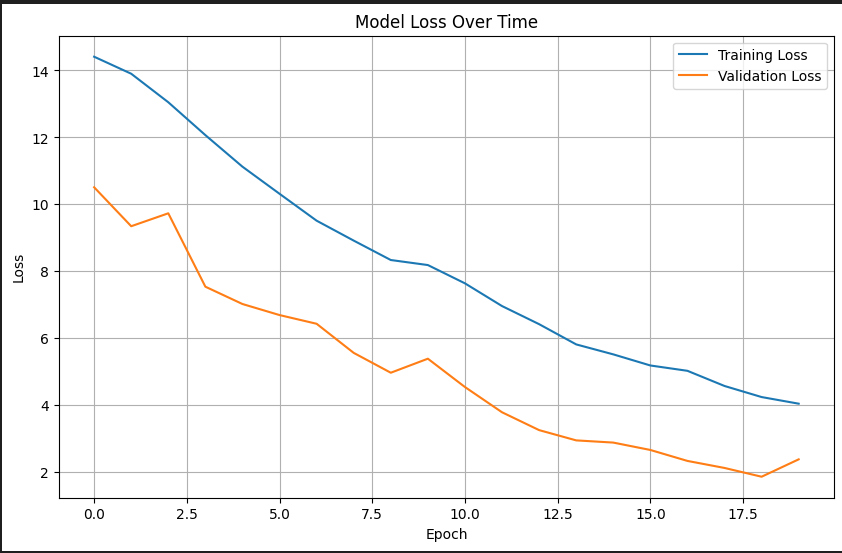

I wasn't sure if this small uptick in validation loss was a sign of overfitting or not, so I decided to train for another 10 epochs to see what would happen.

In [46]:
model.load_weights('models/50epoch.weights.h5')
model.fit(train, validation_data=test, epochs = 10, callbacks=[checkpoint_callback, example_callback])

Epoch 1/10


2025-01-12 13:16:58.430576: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-01-12 13:17:05.447574: I external/local_xla/xla/service/service.cc:168] XLA service 0x724ba8a610e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-12 13:17:05.447594: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-01-12 13:17:05.456127: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736687825.537017    4237 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 84/450 [====>.........................] - ETA: 2:47 - loss: 3.9455

[mpeg1video @ 0x7249b8068c00] ac-tex damaged at 22 17
[mpeg1video @ 0x7249b8068c00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 3.7709

[mpeg1video @ 0x724af80582c0] ac-tex damaged at 22 17
[mpeg1video @ 0x724af80582c0] Warning MVs not available
2025-01-12 13:22:21.743040: W external/local_tsl/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


Epoch 1 finished
450/450 [==============================] - 354s 754ms/step - loss: 3.7709 - val_loss: 1.9708
Epoch 2/10
450/450 [==============================] - ETA: 0s - loss: 3.6516

[mpeg1video @ 0x724b4008e6c0] ac-tex damaged at 22 17
[mpeg1video @ 0x724b4008e6c0] Warning MVs not available


Epoch 2 finished
450/450 [==============================] - 328s 729ms/step - loss: 3.6516 - val_loss: 1.8207
Epoch 3/10
149/450 [========>.....................] - ETA: 2:20 - loss: 3.6270

[mpeg1video @ 0x724aa4080440] ac-tex damaged at 22 17
[mpeg1video @ 0x724aa4080440] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 3.4616

[mpeg1video @ 0x7249d806ee00] ac-tex damaged at 22 17
[mpeg1video @ 0x7249d806ee00] Warning MVs not available


Epoch 3 finished
450/450 [==============================] - 325s 723ms/step - loss: 3.4616 - val_loss: 2.5808
Epoch 4/10
  6/450 [..............................] - ETA: 3:25 - loss: 3.8613

[mpeg1video @ 0x7249c8094000] ac-tex damaged at 22 17
[mpeg1video @ 0x7249c8094000] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 3.3662

[mpeg1video @ 0x724afc11c3c0] ac-tex damaged at 22 17
[mpeg1video @ 0x724afc11c3c0] Warning MVs not available


Epoch 4 finished
450/450 [==============================] - 322s 717ms/step - loss: 3.3662 - val_loss: 1.3109
Epoch 5/10
400/450 [=========================>....] - ETA: 22s - loss: 3.0520

[mpeg1video @ 0x724b10089e00] ac-tex damaged at 22 17
[mpeg1video @ 0x724b10089e00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 3.0726

[mpeg1video @ 0x7249b8169780] ac-tex damaged at 22 17
[mpeg1video @ 0x7249b8169780] Warning MVs not available


Epoch 5 finished


[mpeg1video @ 0x724a9801bd00] ac-tex damaged at 22 17
[mpeg1video @ 0x724a9801bd00] Warning MVs not available


1/1 [==============================] - 1s 862ms/step
Original: bin blue with r zero soon
Prediction: bin blue with r zero son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue with a nine now
Prediction: place blue with a nine now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 426s 947ms/step - loss: 3.0726 - val_loss: 1.5278
Epoch 6/10
386/450 [========================>.....] - ETA: 29s - loss: 2.9446

[mpeg1video @ 0x7249f801c280] ac-tex damaged at 22 17
[mpeg1video @ 0x7249f801c280] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 2.8990

[mpeg1video @ 0x7249c0064740] ac-tex damaged at 22 17
[mpeg1video @ 0x7249c0064740] Warning MVs not available


Epoch 6 finished
450/450 [==============================] - 325s 723ms/step - loss: 2.8990 - val_loss: 0.9726
Epoch 7/10
172/450 [==========>...................] - ETA: 2:08 - loss: 2.7601

[mpeg1video @ 0x724b9005ae80] ac-tex damaged at 22 17
[mpeg1video @ 0x724b9005ae80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 2.5645

[mpeg1video @ 0x724aa4007580] ac-tex damaged at 22 17
[mpeg1video @ 0x724aa4007580] Warning MVs not available


Epoch 7 finished
450/450 [==============================] - 325s 724ms/step - loss: 2.5645 - val_loss: 0.9270
Epoch 8/10
450/450 [==============================] - ETA: 0s - loss: 2.4520

[mpeg1video @ 0x724b8809a240] ac-tex damaged at 22 17
[mpeg1video @ 0x724b8809a240] Warning MVs not available


Epoch 8 finished
450/450 [==============================] - 324s 721ms/step - loss: 2.4520 - val_loss: 0.9838
Epoch 9/10
318/450 [====================>.........] - ETA: 1:01 - loss: 2.3936

[mpeg1video @ 0x7249b8012ac0] ac-tex damaged at 22 17
[mpeg1video @ 0x7249b8012ac0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 2.3530

[mpeg1video @ 0x7249e0025f00] ac-tex damaged at 22 17
[mpeg1video @ 0x7249e0025f00] Warning MVs not available


Epoch 9 finished
450/450 [==============================] - 325s 723ms/step - loss: 2.3530 - val_loss: 0.9818
Epoch 10/10
280/450 [=================>............] - ETA: 1:18 - loss: 2.3682

[mpeg1video @ 0x724ae00159c0] ac-tex damaged at 22 17
[mpeg1video @ 0x724ae00159c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 2.2311

[mpeg1video @ 0x724aec003640] ac-tex damaged at 22 17
[mpeg1video @ 0x724aec003640] Warning MVs not available


Epoch 10 finished
1/1 [==============================] - 0s 87ms/step
Original: bin blue in p nine please
Prediction: bin blue in p nine please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red by k eight soon
Prediction: bin red by k eight son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 325s 722ms/step - loss: 2.2311 - val_loss: 0.6824


- Note - I am not sure why I am getting the warnings about ac-tex damaged and MVs not available, I have tried to mute them as they do not seem to hinder training but it has not worked. The fact it happens once during training and once during validation (consistently) tells me some of my files are corrupt, but I have checked them all and they are fine. I think it may be an Ubuntu problem as I did not have these problems when I was working on Windows. I'm sorry it makes it quite ugly to look at.

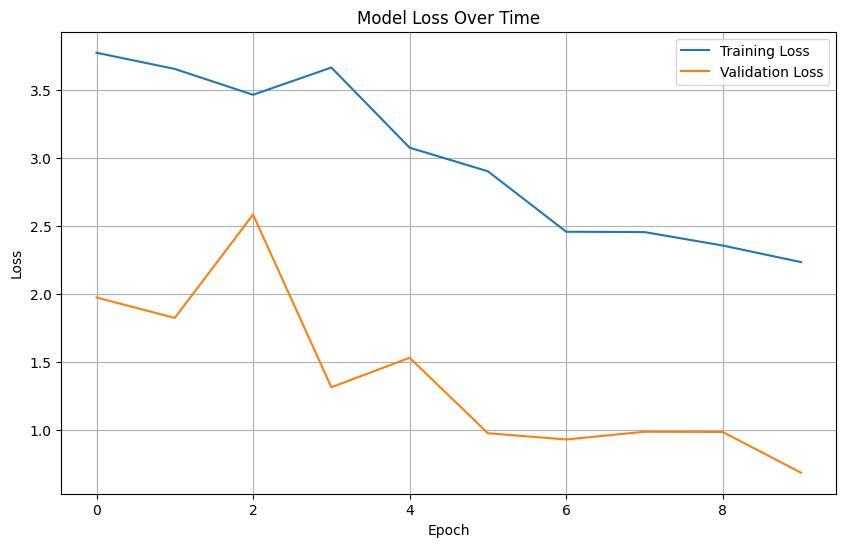

In [60]:
model.load_weights('models/60epoch.weights.h5')
history = model.history.history

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')

# Customize the plot
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

As we can see, we have reached a validation loss of less than one, and we have not yet overfit. Lets try testing on other samples to see how we are performing.

In [35]:
model.load_weights('models/50epoch.weights.h5')

In [57]:
sample = load_data(tf.convert_to_tensor('./s20vids/lgbk3n.mpg'), 's20vids', 'align') # load a file from the dataset (feel free to change the file)
text = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]] # load the text from the file

In [50]:
guess = model.predict(tf.expand_dims(sample[0], axis=0))    # predict the text using the video
decoded = tf.keras.backend.ctc_decode(guess, input_length=[75], greedy=True)[0][0].numpy()
pred = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

1/1 [==============================] - 0s 79ms/step


In [51]:
print(f"Video Text = {text}")   # print both actual text and predicted text
print(f"Predicted Text = {pred}")

Video Text = [<tf.Tensor: shape=(), dtype=string, numpy=b'lay green by k three now'>]
Predicted Text = [<tf.Tensor: shape=(), dtype=string, numpy=b'lay green by k three now'>]


Ok, we seem to have good performance, although we sometimes miss the single letter. This is the most difficult part of the task because of how similiar the mouth movements are for single sounds. Just for fun, let's try testing on a different speaker from the corpus. It is wise to choose a speaker with a similiar skin tone as the speaker we trained on, as our method relies on distinguishing light pixels from dark pixels to see mouth movements. This is obviously a flaw in the method but I did not set out with the aim of making this a widely generalisable model, although that is a very exciting prospect. I decided to use speaker 11 to to test the model because they are both white and female. I hoped this would give the model the best chance of generalising.

# Testing on another speaker

I created some new functions here just to maintain functionality in the existing code, I did not want to break anything so I have repeated some code here.

In [85]:
def load_datas11(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('.', 's11vids', f'{file_name}.mpg')
    alignment_path = os.path.join('.', 's11align', f'{file_name}.align')
    
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video file not found: {video_path}")
    if not os.path.exists(alignment_path):
        raise FileNotFoundError(f"Alignment file not found: {alignment_path}")
    
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    return frames, alignments

In [99]:
s11testing = './s11vids/bwas4p.mpg'

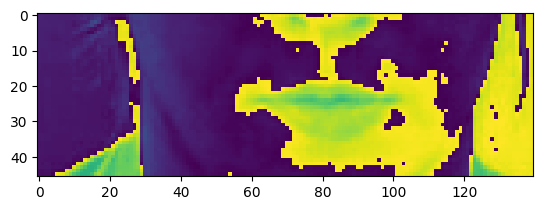

In [101]:
frames, alignments = load_datas11(tf.convert_to_tensor(s11testing))
plt.imshow(frames[34])

In [102]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin white at s four please'>

In [106]:
def s11mappable_function(path:str) ->Tuple[tf.Tensor, tf.Tensor]:
      result = tf.py_function(load_datas11, [path], (tf.float32, tf.int64))
      return result #format data for tensorflow

In [114]:
s11data = tf.data.Dataset.list_files('./s11vids/*.mpg')
s11data = s11data.map(s11mappable_function)
s11data = s11data.padded_batch(1, padded_shapes=([75,None,None,None],[40]))
s11data = s11data.prefetch(tf.data.AUTOTUNE)

In [115]:
s11data = s11data.as_numpy_iterator()

In [116]:
for _ in range(14):  
    sample = s11data.next()
    guess = model.predict(sample[0])
    decoded = tf.keras.backend.ctc_decode(guess, input_length=[75], greedy=True)[0][0].numpy()
    
    for i in range(len(sample[0])):
        print("Original:", tf.strings.reduce_join(num_to_char(sample[1][i])).numpy().decode('utf-8'))
        print("Predicted:", tf.strings.reduce_join(num_to_char(decoded[i])).numpy().decode('utf-8'))
        print('~' * 100)

1/1 [==============================] - 0s 69ms/step
Original: lay blue with d four now
Predicted: lay gre winh g fige noain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1/1 [==============================] - 0s 65ms/step
Original: place blue by u eight please
Predicted: set blue wit ive sow
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1/1 [==============================] - 0s 68ms/step
Original: place red in b two now
Predicted: lace blue ith i ive ne
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1/1 [==============================] - 0s 66ms/step
Original: set blue by m seven soon
Predicted: la white with h tie again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1/1 [==============================] - 0s 69ms/step
Original: lay white in x nine again
Predicted: lia blu

Looking at these results there is some correct words, although some samples are completely wrong. Whether this is concrete evidence of generalisation is debatable, as the model may just be getting lucky. However, samples such as


"Original: lay green at e six please
Predicted: la grie it g tixe again"

do give me hope as, to me, it seems as though the model is actually trying to read and getting nonsense words that are close to what is being said, instead of just guessing words it already knows. 

# Conclusion

I think I have achieved what I set out to do, I have consistent and reliable lipreading on one speaker, and have some evidence of generalisability. The model could perhaps be trained more, but a validation loss of less than one is acceptable to me. I think I avoided overfitting by using Dropout in my model, and although this may have slowed down training and made the loss values a little confusing it definetely helped avoid overfitting. I learned a lot, not only about movement classification, but also computer vision and lip reading in general. If you have time, I recommend reading the full LipNet paper, it is really interesting and goes deeper into how we create certain sounds and how the machine can interpret these. In future I may try to increase the generalisability of this model, as I believe it can be a really powerful tool. There are, of course, privacy concerns, as companies may use this technology, combined with facial recognition software such as ClearView AI to log peoples conversations and associate them with their identities, leading to a serious privacy violation and, unfortunately, opportunity for more targeted advertising or surveillance. 

References - <br><br>M. Yannis, B. Shillingford, S. Whiteson, N. de Freitas - "LipNet: End-to-End Sentence-level Lipreading", 2016, Google DeepMind, University of Oxford
<br><br> A. Graves, S. Fernandez, F. Gomez, J. Schmidhuber - "Connectionist Temporal Classification: Labelling Unsegmented Sequence Data with Recurrent Neural Networks", 2006, Istituto Dalle Molle di Studi sull’Intelligenza Artificiale
<br><br> F. Chollet - "Deep Learning with Python", 2017, Manning Publications, ISBN 9781617294433
<br><br> J. Wenger - Artificial Intelligence Notebooks, Goldsmiths, University of London
<br><br> M. Rizki - https://github.com/rizkiarm/LipNet
